In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.10.1
GPU detected: []


In [2]:
# data = pd.read_csv("kaggle/input/ner_dataset.csv", encoding="latin1")
# data = data.fillna(method="ffill")
data = pd.read_parquet('kaggle/input/cord-ner-full.parquet.gzip')
#data = pd.read_csv("kaggle/input/covid_subset_3perc.csv", encoding="latin1")

In [3]:
print("Unique words in corpus:", data['word'].nunique())
print("Unique tags in corpus:", data['entity'].nunique())
print("Unique sentences in corpus:", data['sentence'].nunique())
data['word'].describe()

Unique words in corpus: 951345
Unique tags in corpus: 125
Unique sentences in corpus: 140073


count     63308700
unique      951345
top            the
freq       3265577
Name: word, dtype: object

In [ ]:
df1 = data[data['sentence'] < 1000]
# df1 = pd.DataFrame(df1_np, columns = data.columns)
print("Unique words in corpus:", df1['word'].nunique())
print("Unique tags in corpus:", df1['entity'].nunique())
print("Unique sentences in corpus:", df1['sentence'].nunique())
df1.describe()
df1.to_csv('kaggle/input/covid_subset_0.5perc.csv', index=False)

In [10]:
import sys
!{sys.executable} -m pip install fastparquet

  Using cached fastparquet-2023.1.0-cp310-cp310-win_amd64.whl (616 kB)



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: C:\Users\kreti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

def preprocess_text(sentences):

    lemmatizer = WordNetLemmatizer()
    all_words = []
    for sentence in sentences:
        array = []
        for token, tag, category in sentence:
            if pos := get_wordnet_pos(tag):
                lemm_token = lemmatizer.lemmatize(token, pos)
                array.append((lemm_token, tag, category))
                all_words.append(lemm_token)
            else:
                array.append((token, tag, category))
                all_words.append(token)

    return array, words

In [15]:
import nltk
from nltk import pos_tag
nltk.download('wordnet')



words = list(set(lemmatize_tokens(data["Word"].values)))
words.append("ENDPAD")
print(len(words))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kreti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


32671


In [6]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
print(num_words)

35179


In [7]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [8]:
print(num_words, num_tags)

35179 17


In [27]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [30]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [31]:
sentences, words = preprocess_text(sentences)
print(len(sentences), len(words))

words = list(set(words))
words.append("ENDPAD")
num_words = len(words)
print(num_words)

32 1083754
36374


In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
word2idx

{'anti-retroviral': 1,
 'el-Bared': 2,
 'trafficked': 3,
 'XP': 4,
 'stockpile': 5,
 'Dany': 6,
 'Ministries': 7,
 '23rd': 8,
 'others': 9,
 '1939': 10,
 'cordon': 11,
 'thermal': 12,
 'stranded': 13,
 'Crescent': 14,
 'Africa': 15,
 'Lithuanians': 16,
 'Twenty-three': 17,
 'nation-state': 18,
 'satisfies': 19,
 'Shahdi': 20,
 'conjured': 21,
 'EPA': 22,
 'Heliodoro': 23,
 'Sasae': 24,
 'Product': 25,
 'appeasing': 26,
 'Koirala': 27,
 'ideas': 28,
 'idolatry': 29,
 'Badme': 30,
 'Marti': 31,
 'Kirilenko': 32,
 'Jebel': 33,
 'players': 34,
 'ome': 35,
 'Hoop': 36,
 'Straw': 37,
 'exceptions': 38,
 'stir': 39,
 'Torrijos': 40,
 'Guenther': 41,
 'suis': 42,
 'eggplant': 43,
 'Lynn': 44,
 'nonrefundable': 45,
 'Movie': 46,
 'tyrants': 47,
 'herd': 48,
 'Mujuru': 49,
 'pick-up': 50,
 'plaguing': 51,
 'peshmerga': 52,
 'Gereida': 53,
 'Understanding': 54,
 'denounce': 55,
 'Aharonot': 56,
 '8,50,000': 57,
 'clamping': 58,
 'U.S.-funded': 59,
 'happened': 60,
 'Dome': 61,
 'guarantees': 62,


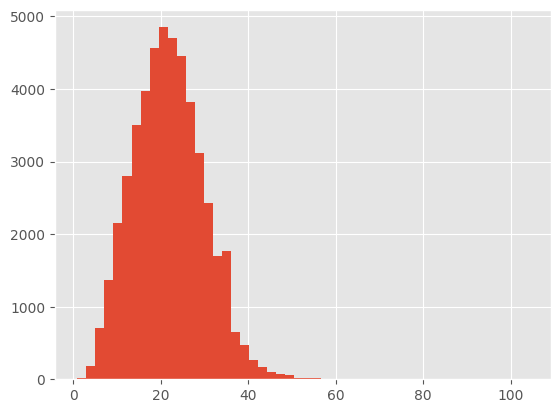

In [10]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    verbose=1
)

model.evaluate(x_test, y_test)

Epoch 1/3
1199/1199 [==============================] - 109s 87ms/step - loss: 0.1721 - accuracy: 0.9611 - val_loss: 0.0651 - val_accuracy: 0.9815
Epoch 2/3
1199/1199 [==============================] - 105s 87ms/step - loss: 0.0504 - accuracy: 0.9851 - val_loss: 0.0515 - val_accuracy: 0.9848
Epoch 3/3
300/300 [==============================] - 7s 22ms/step - loss: 0.0479 - accuracy: 0.9859


[0.04792255908250809, 0.9858694672584534]

In [27]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 33ms/step
[[0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  1.   0.   0.  ]
 [0.   0.   0.01 0.94 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.03 0.   0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0

In [26]:
idx2tag = {i: w for w, i in tag2idx.items()}
idx2word = {i: w for w, i in word2idx.items()}

tags = []
for word in p[i]:
    tags.append(idx2tag[word])
sentence = []
for word in x_test[i]:
    sentence.append(idx2word[word])

print(sentence, tags)

IndexError: index 7891 is out of bounds for axis 0 with size 1